In [233]:
import os
import glob
import json
import pandas as pd
import numpy as np

from itertools import groupby
from collections import Counter
from os.path import exists

In [234]:
def IssuerCode(state=False):
    issuers = pd.read_csv('data/s&p500.csv',sep=';')
    issuer_filtered = []
    for code_stock in issuers.Ticker:
        # Check last transaction 2023
        # Have 200 transaction
        path = f'data/transactions/{code_stock}.csv'
        if os.path.exists(path):
            historical = pd.read_csv(path)
            last_date_row = historical.Date.iloc[len(historical)-1] # get last date transactions
            data_test = historical[-1000:]['Close'] # get data test
            var = np.var(data_test) # calculate variance from data test
            if (last_date_row[:4] == '2023' and len(historical) >= 200 and var > 0):
                issuer_filtered.append(code_stock)
    
    if state:
        print("Code of Stock Issuer: {}".format(issuer_filtered))
    else:
        return issuer_filtered

In [235]:
issuers = IssuerCode()

In [236]:
path_transaction = 'data/transactions/'

issuer_sectors = {'code':[],'len':[]}

for issuer in issuers:    
    path = f'{path_transaction}{issuer}.csv'
    if exists(path):
        historical = pd.read_csv(path)
        issuer_sectors['code'].append(issuer)
        issuer_sectors['len'].append(len(historical))

In [237]:
issuer_result = {'code':[],'lookback':[],'arch':[],'r2':[],'mse':[],'rmse':[],'mape':[],'acc':[],'f1':[]}

lookbacks = [5,10,15,20,25]
architecture = ['TFGRU', 'TFLSTM', 'TFGRULSTM', 'TFLSTMGRU']

path_result = 'results/evaluations/'

for code in issuers:
    for archi in architecture:
        for lookback in lookbacks:
            if 'GCN' in archi:
                path_score = f'{path_result}{archi}_multivariate_graph/{code}_{lookback}_test_score.json'
                path_class = f'{path_result}{archi}_multivariate_graph/{code}_{lookback}_test_classification.json'
            else:
                path_score = f'{path_result}{archi}_multivariate/{code}_{lookback}_test_score.json'
                path_class = f'{path_result}{archi}_multivariate/{code}_{lookback}_test_classification.json'
            
            score_json = json.load(open(path_score))
            class_json = json.load(open(path_class))
            
            issuer_result['code'].append(code)
            issuer_result['lookback'].append(lookback)
            issuer_result['arch'].append(archi)
            issuer_result['r2'].append(score_json['R2'])
            issuer_result['mse'].append(score_json['MSE'])
            issuer_result['rmse'].append(score_json['RMSE'])
            issuer_result['mape'].append(score_json['MAPE'])
            issuer_result['acc'].append(class_json['accuracy'])
            issuer_result['f1'].append(class_json['macro avg']['f1-score'] if 'macro avg' in class_json else 0)

In [238]:
df_result = pd.DataFrame(issuer_result)
df_averages = df_result.groupby(['code', 'arch'], as_index=False).mean()[['code','arch', 'r2', 'mse', 'rmse', 'mape', 'acc', 'f1']]

best_arch_r2 = df_averages.loc[df_averages.groupby(['code'])['r2'].idxmax()]
best_arch_mse = df_averages.loc[df_averages.groupby(['code'])['mse'].idxmin()]
best_arch_rmse = df_averages.loc[df_averages.groupby(['code'])['rmse'].idxmin()]
best_arch_mape = df_averages.loc[df_averages.groupby(['code'])['mape'].idxmin()]
best_arch_f1 = df_averages.loc[df_averages.groupby(['code'])['f1'].idxmax()]

df_best = pd.concat([best_arch_r2, best_arch_mse, best_arch_rmse, best_arch_mape, best_arch_f1])

df_best_arch = df_best.groupby(['code', 'arch'], as_index=False).count()[['code', 'arch', 'r2']]
best_arch = df_best_arch.loc[df_best_arch.groupby(['code'])['r2'].idxmax()]
best_arch = best_arch.rename(columns={'r2': 'count'})
best_arch_count = best_arch.groupby(['arch'], as_index=False).count()[['arch','count']]

        arch  count
1  TFLSTMGRU      1
0      TFGRU      9


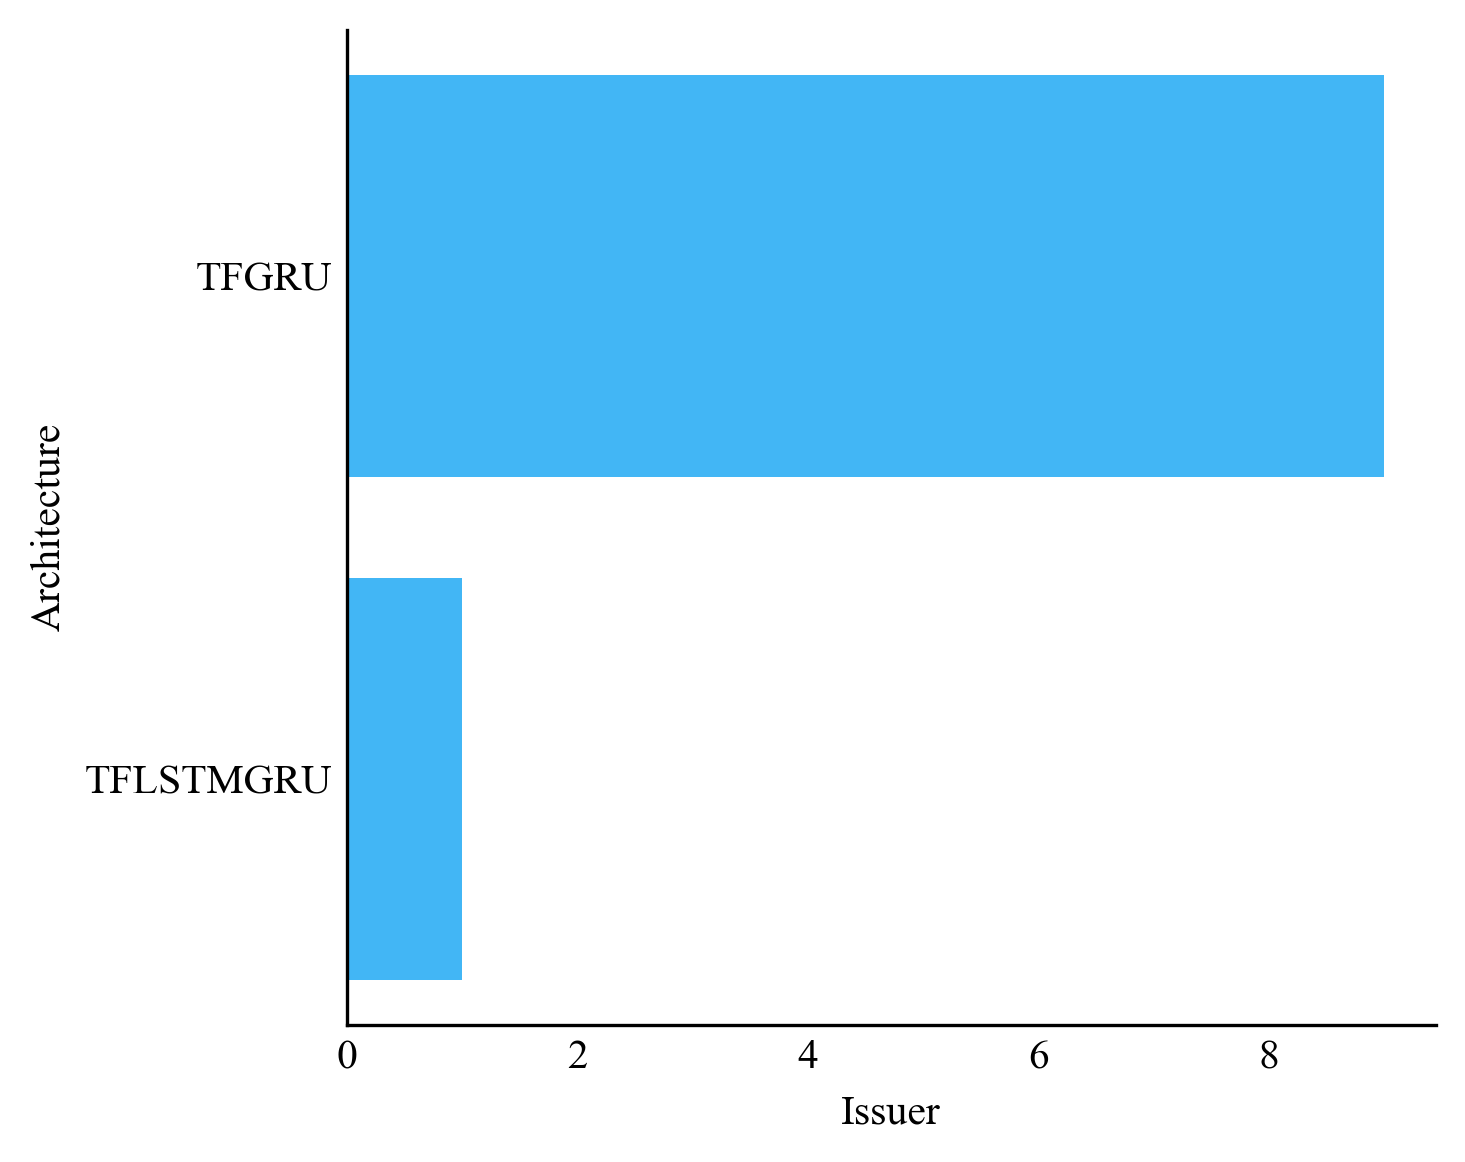

In [239]:
import matplotlib.pyplot as plt
plt.rcdefaults()
plt.rcParams.update({'font.family':'Times New Roman'})
fig = plt.figure(figsize =(5, 4))

# bar_colors = ['#4287f5', '#42f5a3', '#f54242', '#f5d142', '#a342f5', '#f57f42', '#42b6f5', '#f542c6', '#42f5e9', '#c6f542', '#f5bc42']
df = best_arch_count.sort_values('count', ascending=True)
print(df)
plt.barh(df['arch'], df['count'], color='#42b6f5')
plt.xlabel('Issuer')
plt.ylabel('Architecture')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tick_params(axis='both', which='both', length=0, labelsize=10)
plt.tight_layout()

fig.set_dpi(300.0)
plt.show()

In [240]:
df_result = pd.DataFrame(issuer_result)
# df_averages_score = df_result.groupby(['arch'], as_index=False).mean()[['arch', 'r2', 'mse', 'rmse', 'mape', 'acc', 'f1']]
df_averages_score = df_result[['arch', 'r2', 'mse', 'rmse', 'mape', 'acc', 'f1']]
df_averages_score.to_excel('df_averages_score.xlsx', index=False)

          arch        r2           mse        rmse      mape       acc  \
110  TFGRULSTM -0.633436  18033.351770  134.288316  0.464194  0.481481   
111  TFGRULSTM -0.588242  17534.407108  132.417548  0.491736  0.485485   
115  TFLSTMGRU -0.530697  16899.105966  129.996561  0.447185  0.481481   
105     TFLSTM -0.528390  16873.630520  129.898539  0.454986  0.488488   
116  TFLSTMGRU -0.514768  16723.250230  129.318406  0.431219  0.472472   
..         ...       ...           ...         ...       ...       ...   
183      TFGRU  0.990582      6.070215    2.463781  0.033621  0.489489   
163      TFGRU  0.990894     98.746815    9.937143  0.021653  0.508509   
184      TFGRU  0.991282      5.618760    2.370392  0.029312  0.493493   
2        TFGRU  0.992051     11.860955    3.443974  0.020086  0.536537   
4        TFGRU  0.992478     11.223702    3.350179  0.019695  0.554555   

           f1  
110  0.442868  
111  0.463325  
115  0.446543  
105  0.466231  
116  0.377619  
..        ...  

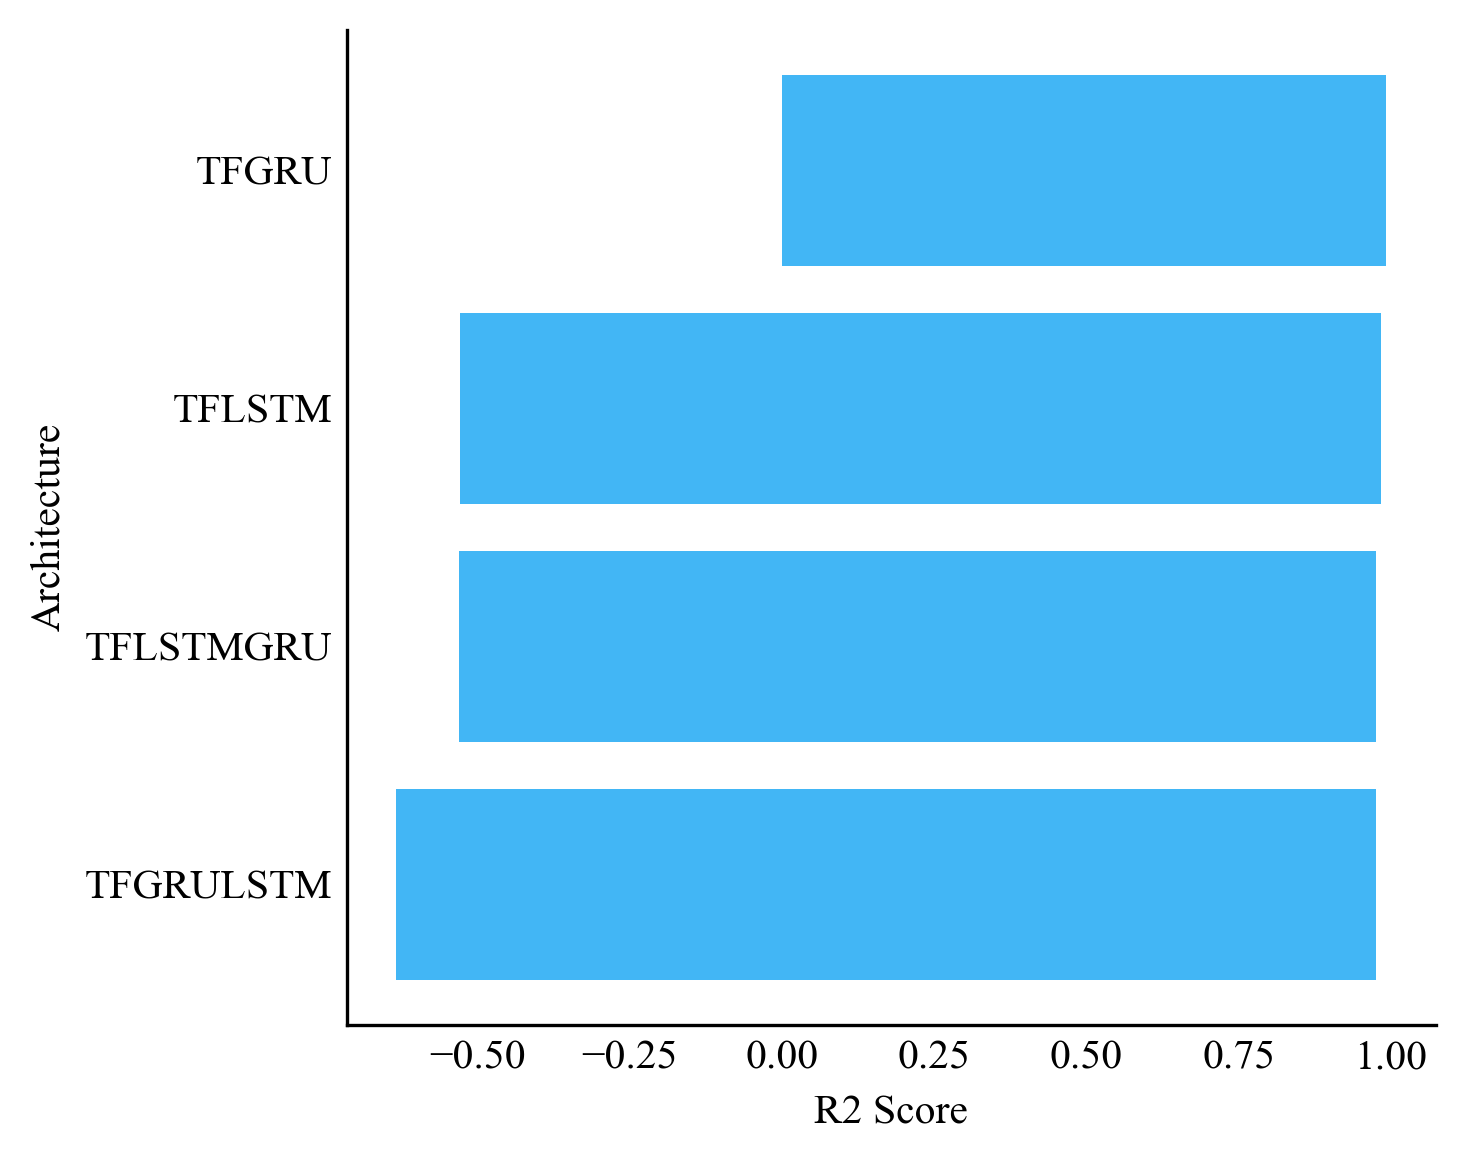

In [241]:
import matplotlib.pyplot as plt
plt.rcdefaults()
plt.rcParams.update({'font.family':'Times New Roman'})
fig = plt.figure(figsize =(5, 4))

df = df_averages_score.sort_values('r2', ascending=True)
print(df)
plt.barh(df['arch'], df['r2'], color='#42b6f5')
plt.xlabel('R2 Score')
plt.ylabel('Architecture')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tick_params(axis='both', which='both', length=0, labelsize=10)
plt.tight_layout()

fig.set_dpi(300.0)
plt.show()

          arch        r2           mse        rmse      mape       acc  \
110  TFGRULSTM -0.633436  18033.351770  134.288316  0.464194  0.481481   
111  TFGRULSTM -0.588242  17534.407108  132.417548  0.491736  0.485485   
115  TFLSTMGRU -0.530697  16899.105966  129.996561  0.447185  0.481481   
105     TFLSTM -0.528390  16873.630520  129.898539  0.454986  0.488488   
116  TFLSTMGRU -0.514768  16723.250230  129.318406  0.431219  0.472472   
..         ...       ...           ...         ...       ...       ...   
4        TFGRU  0.992478     11.223702    3.350179  0.019695  0.554555   
181      TFGRU  0.989840      6.548166    2.558938  0.029341  0.483483   
182      TFGRU  0.990149      6.349484    2.519818  0.028904  0.482482   
183      TFGRU  0.990582      6.070215    2.463781  0.033621  0.489489   
184      TFGRU  0.991282      5.618760    2.370392  0.029312  0.493493   

           f1  
110  0.442868  
111  0.463325  
115  0.446543  
105  0.466231  
116  0.377619  
..        ...  

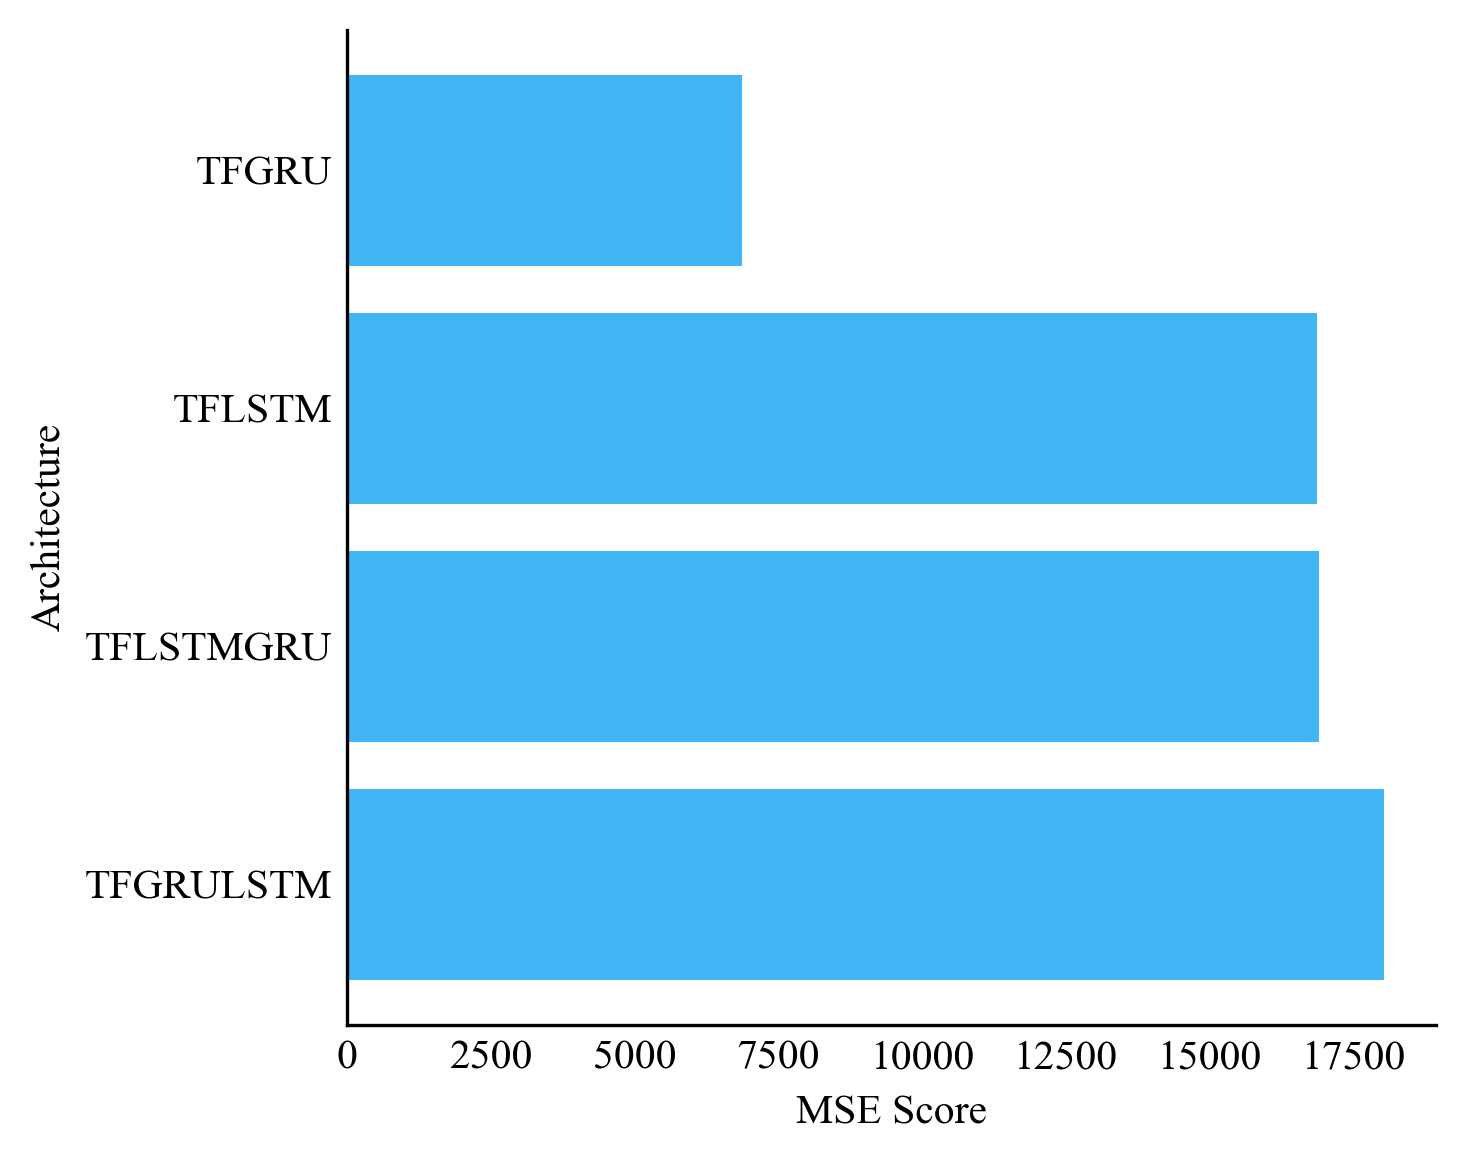

In [242]:
import matplotlib.pyplot as plt
plt.rcdefaults()
plt.rcParams.update({'font.family':'Times New Roman'})
fig = plt.figure(figsize =(5, 4))

df = df_averages_score.sort_values('mse', ascending=False)
print(df)
plt.barh(df['arch'], df['mse'], color='#42b6f5')
plt.xlabel('MSE Score')
plt.ylabel('Architecture')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tick_params(axis='both', which='both', length=0, labelsize=10)
plt.tight_layout()

fig.set_dpi(300.0)
plt.show()

          arch        r2           mse        rmse      mape       acc  \
110  TFGRULSTM -0.633436  18033.351770  134.288316  0.464194  0.481481   
111  TFGRULSTM -0.588242  17534.407108  132.417548  0.491736  0.485485   
115  TFLSTMGRU -0.530697  16899.105966  129.996561  0.447185  0.481481   
105     TFLSTM -0.528390  16873.630520  129.898539  0.454986  0.488488   
116  TFLSTMGRU -0.514768  16723.250230  129.318406  0.431219  0.472472   
..         ...       ...           ...         ...       ...       ...   
4        TFGRU  0.992478     11.223702    3.350179  0.019695  0.554555   
181      TFGRU  0.989840      6.548166    2.558938  0.029341  0.483483   
182      TFGRU  0.990149      6.349484    2.519818  0.028904  0.482482   
183      TFGRU  0.990582      6.070215    2.463781  0.033621  0.489489   
184      TFGRU  0.991282      5.618760    2.370392  0.029312  0.493493   

           f1  
110  0.442868  
111  0.463325  
115  0.446543  
105  0.466231  
116  0.377619  
..        ...  

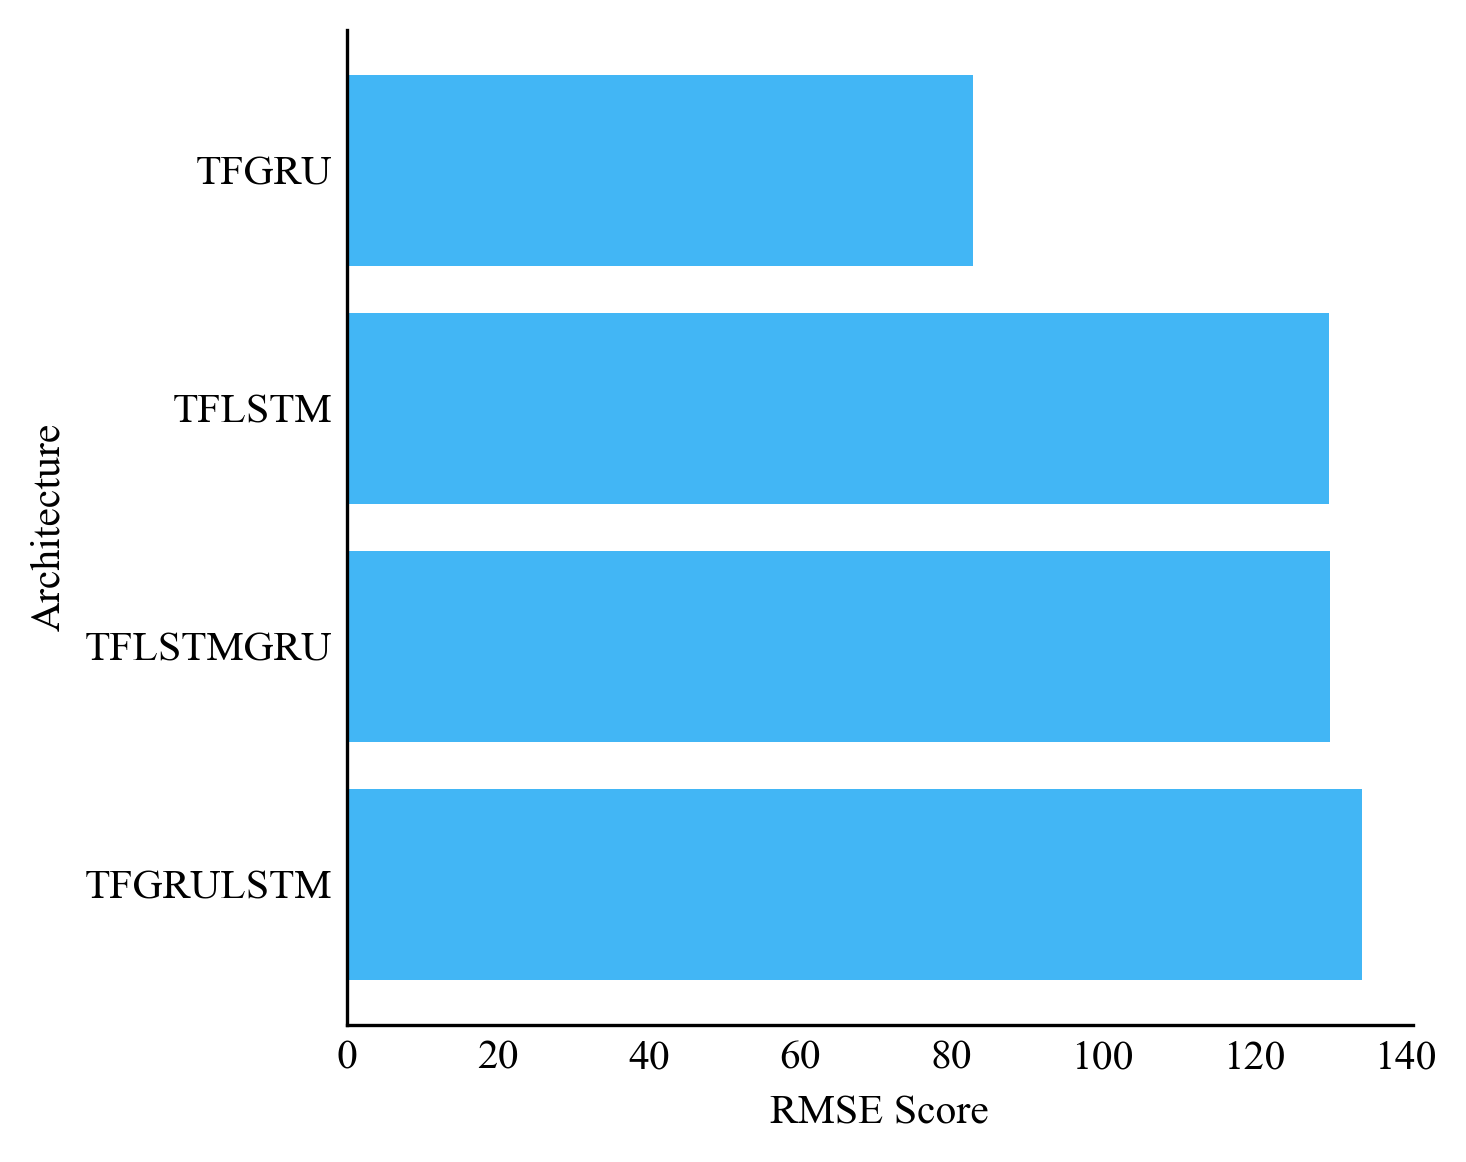

In [243]:
import matplotlib.pyplot as plt
plt.rcdefaults()
plt.rcParams.update({'font.family':'Times New Roman'})
fig = plt.figure(figsize =(5, 4))

df = df_averages_score.sort_values('rmse', ascending=False)
print(df)
plt.barh(df['arch'], df['rmse'], color='#42b6f5')
plt.xlabel('RMSE Score')
plt.ylabel('Architecture')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tick_params(axis='both', which='both', length=0, labelsize=10)
plt.tight_layout()

fig.set_dpi(300.0)
plt.show()

          arch        r2           mse        rmse      mape       acc  \
111  TFGRULSTM -0.588242  17534.407108  132.417548  0.491736  0.485485   
110  TFGRULSTM -0.633436  18033.351770  134.288316  0.464194  0.481481   
105     TFLSTM -0.528390  16873.630520  129.898539  0.454986  0.488488   
115  TFLSTMGRU -0.530697  16899.105966  129.996561  0.447185  0.481481   
116  TFLSTMGRU -0.514768  16723.250230  129.318406  0.431219  0.472472   
..         ...       ...           ...         ...       ...       ...   
162      TFGRU  0.990030    108.121432   10.398146  0.023986  0.510511   
161      TFGRU  0.989999    108.448452   10.413859  0.023865  0.506507   
163      TFGRU  0.990894     98.746815    9.937143  0.021653  0.508509   
2        TFGRU  0.992051     11.860955    3.443974  0.020086  0.536537   
4        TFGRU  0.992478     11.223702    3.350179  0.019695  0.554555   

           f1  
111  0.463325  
110  0.442868  
105  0.466231  
115  0.446543  
116  0.377619  
..        ...  

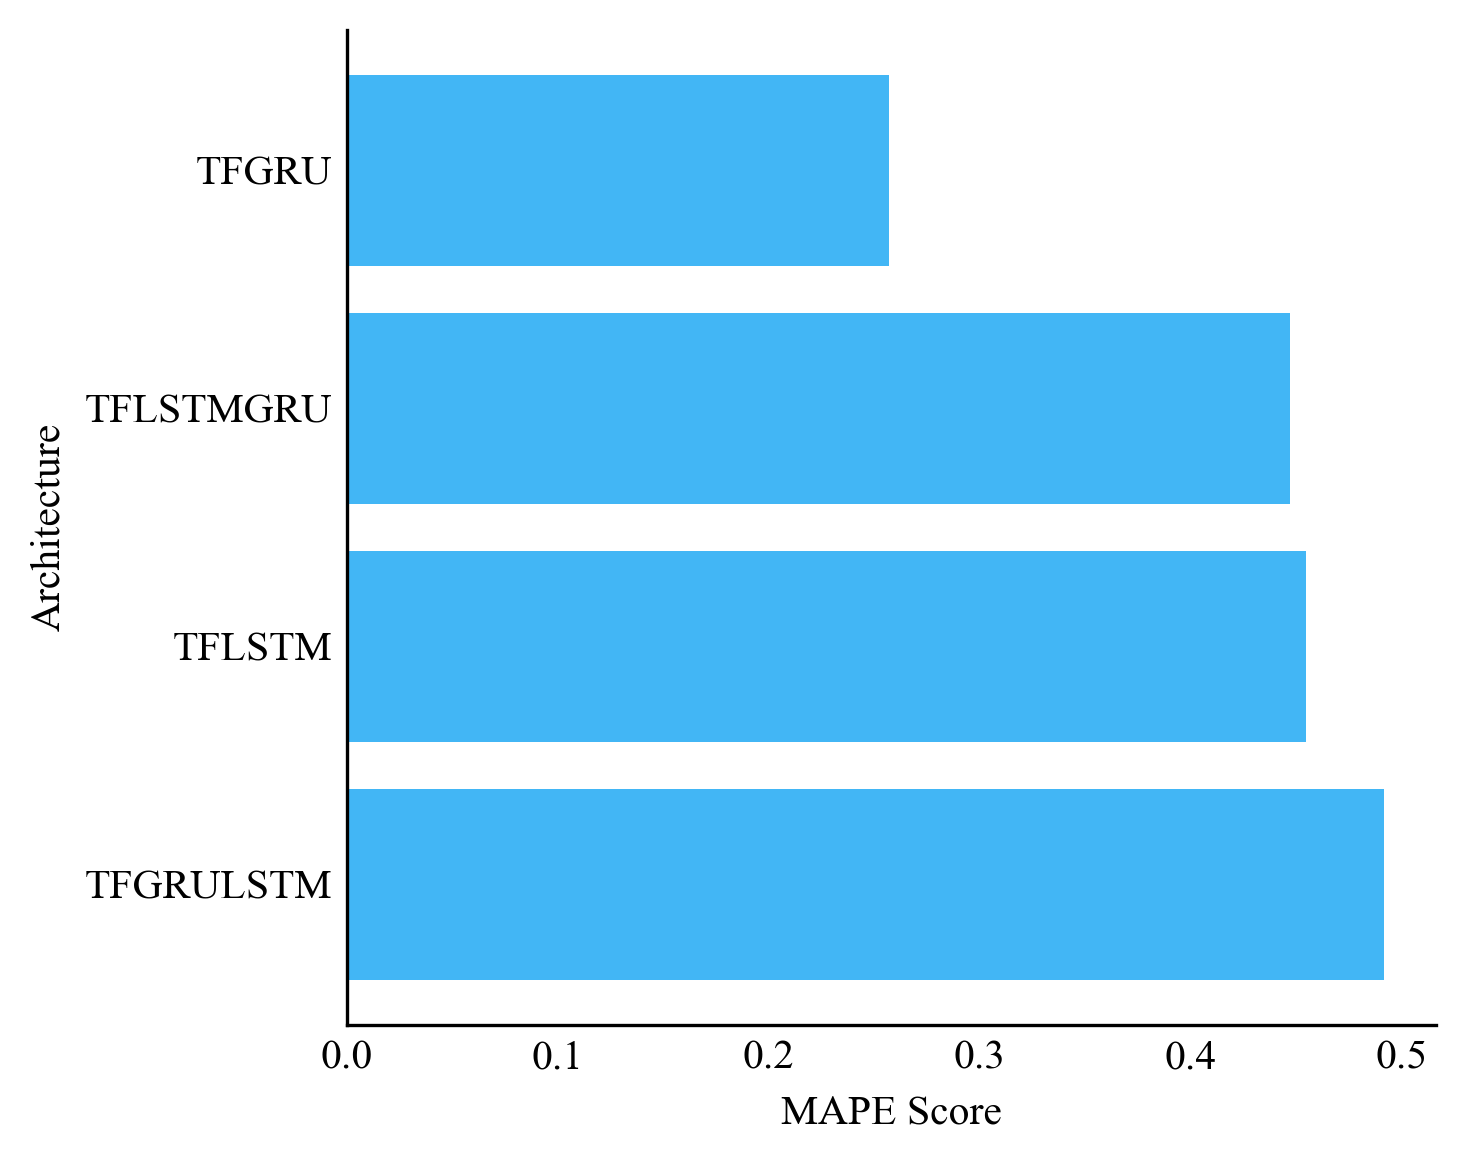

In [244]:
import matplotlib.pyplot as plt
plt.rcdefaults()
plt.rcParams.update({'font.family':'Times New Roman'})
fig = plt.figure(figsize =(5, 4))

df = df_averages_score.sort_values('mape', ascending=False)
print(df)
plt.barh(df['arch'], df['mape'], color='#42b6f5')
plt.xlabel('MAPE Score')
plt.ylabel('Architecture')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tick_params(axis='both', which='both', length=0, labelsize=10)
plt.tight_layout()

fig.set_dpi(300.0)
plt.show()

          arch        r2          mse       rmse      mape       acc        f1
160      TFGRU  0.944127   605.895708  24.614949  0.055284  0.466466  0.327596
104      TFGRU  0.505524  5459.078168  73.885575  0.228042  0.461461  0.334026
41       TFGRU  0.922740    77.431400   8.799511  0.058311  0.480480  0.334408
44       TFGRU  0.911624    88.572811   9.411313  0.062984  0.480480  0.334408
42       TFGRU  0.937738    62.400730   7.899413  0.051297  0.478478  0.341220
..         ...       ...          ...        ...       ...       ...       ...
144      TFGRU  0.979676    15.750409   3.968678  0.029492  0.531532  0.530888
54   TFGRULSTM  0.942245    57.883806   7.608141  0.053872  0.541542  0.531951
33   TFGRULSTM  0.971076    96.860188   9.841757  0.029410  0.539540  0.535157
38   TFLSTMGRU  0.898499   339.904756  18.436506  0.061093  0.539540  0.538685
4        TFGRU  0.992478    11.223702   3.350179  0.019695  0.554555  0.550403

[200 rows x 7 columns]


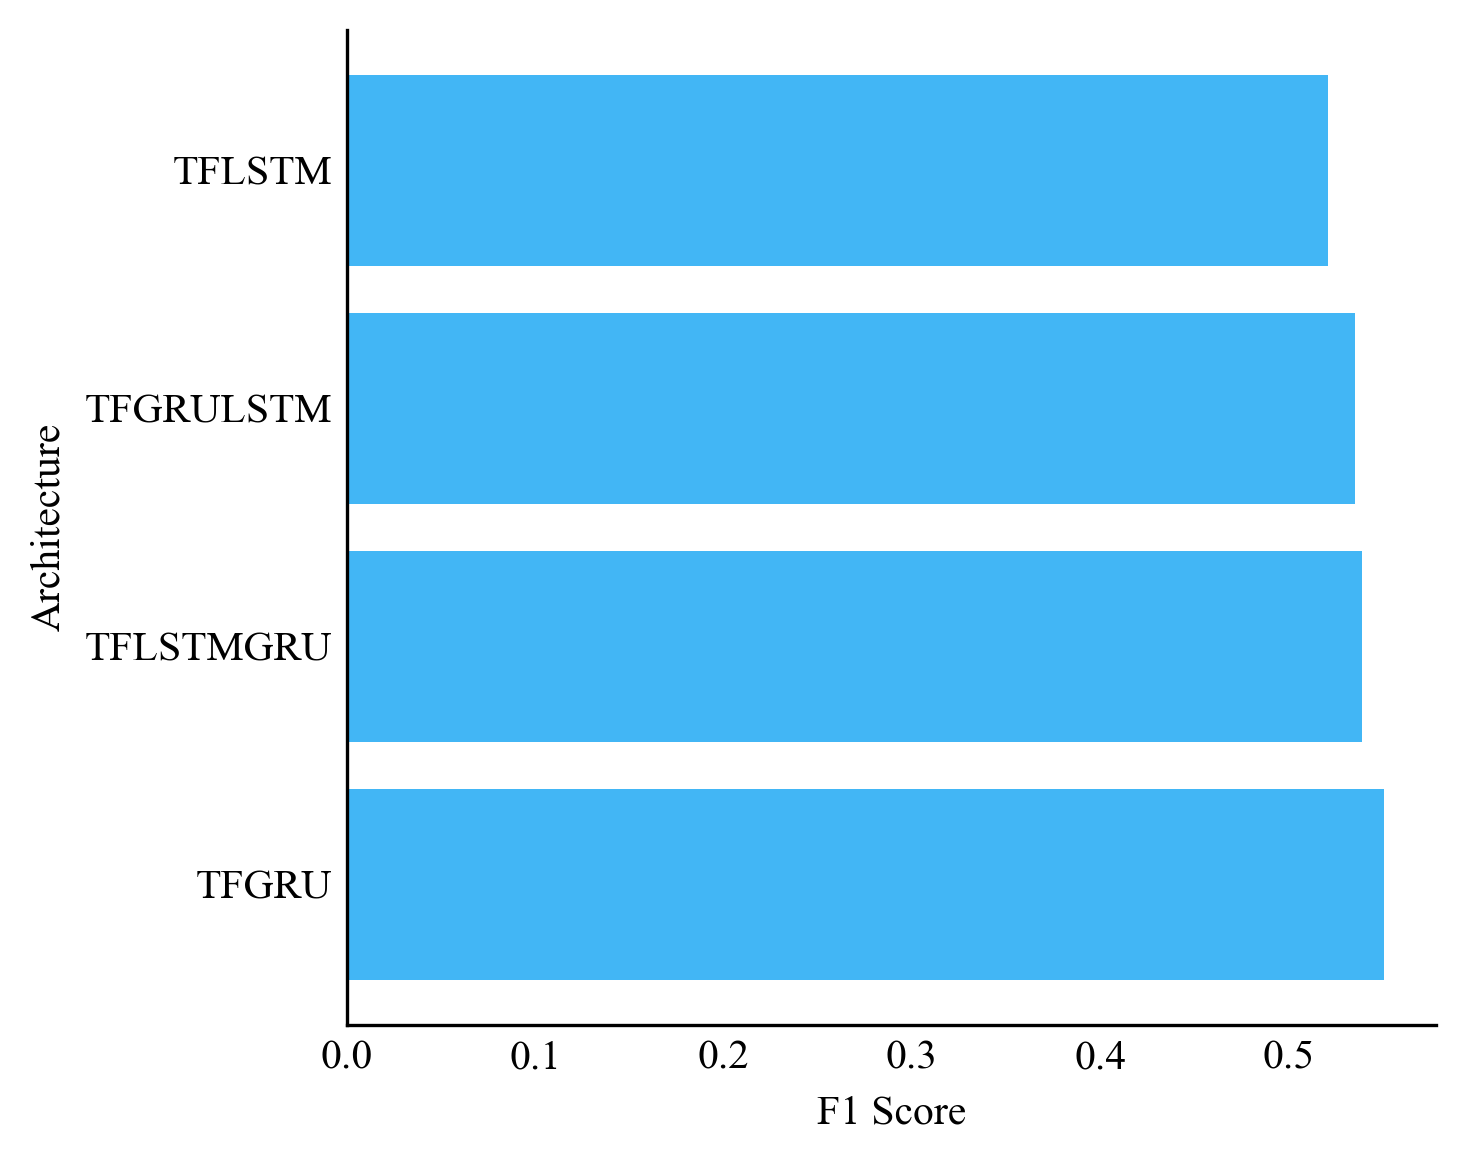

In [245]:
import matplotlib.pyplot as plt
plt.rcdefaults()
plt.rcParams.update({'font.family':'Times New Roman'})
fig = plt.figure(figsize =(5, 4))

df = df_averages_score.sort_values('f1', ascending=True)
print(df)
plt.barh(df['arch'], df['f1'], color='#42b6f5')
plt.xlabel('F1 Score')
plt.ylabel('Architecture')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tick_params(axis='both', which='both', length=0, labelsize=10)
plt.tight_layout()

fig.set_dpi(300.0)
plt.show()

In [246]:
df_result_sort = df_result.sort_values(by=['f1', 'acc', 'mape', 'rmse', 'mse', 'r2'], ascending=[False, False, True, True, True, False])
print(df_result_sort)
# df_result_sort.to_excel('df_result_sort.xlsx', index=False)

     code  lookback       arch        r2          mse       rmse      mape  \
4    AAPL        25      TFGRU  0.992478    11.223702   3.350179  0.019695   
38   MSFT        20  TFLSTMGRU  0.898499   339.904756  18.436506  0.061093   
33   MSFT        20  TFGRULSTM  0.971076    96.860188   9.841757  0.029410   
54   AMZN        25  TFGRULSTM  0.942245    57.883806   7.608141  0.053872   
144  GOOG        25      TFGRU  0.979676    15.750409   3.968678  0.029492   
..    ...       ...        ...       ...          ...        ...       ...   
42   AMZN        15      TFGRU  0.937738    62.400730   7.899413  0.051297   
41   AMZN        10      TFGRU  0.922740    77.431400   8.799511  0.058311   
44   AMZN        25      TFGRU  0.911624    88.572811   9.411313  0.062984   
104  TSLA        25      TFGRU  0.505524  5459.078168  73.885575  0.228042   
160   UNH         5      TFGRU  0.944127   605.895708  24.614949  0.055284   

          acc        f1  
4    0.554555  0.550403  
38   0.5395